In [89]:
import mne
import pandas as pd
import numpy as np
import seaborn as sns
import pywt
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [32]:
df = pd.read_csv('Data/BCICIV_2a_all_patients.csv')

In [33]:
df.head()

,patient,time,label,epoch,EEG-Fz,EEG-0,EEG-1,EEG-2,EEG-3,EEG-4,...,EEG-8,EEG-9,EEG-10,EEG-11,EEG-12,EEG-13,EEG-14,EEG-Pz,EEG-15,EEG-16
0,1,-0.100,tongue,8,-1.681412,2.245496,-0.158350,1.163765,-1.523659,-0.575267,...,0.758116,3.441785,0.305517,1.137473,-1.275763,-2.898359,0.656704,-2.010063,-1.613804,-1.942455
1,1,-0.096,tongue,8,0.420417,0.587559,1.650510,0.970672,1.505904,0.891796,...,1.541586,-0.071620,0.258909,-1.448198,0.142472,-1.968405,-1.733655,-2.935578,-3.125256,-4.674610
2,1,-0.092,tongue,8,0.551365,1.499758,0.121302,2.859433,2.613414,4.636026,...,2.649097,-2.137938,-1.612096,-1.610218,-0.410173,-0.274957,-4.776535,-5.099551,-2.798995,-5.862021
3,1,-0.088,tongue,8,3.054916,-1.807238,1.843603,2.286812,5.995872,6.651295,...,6.031554,-5.249621,-2.672998,-3.452370,0.189081,1.593829,-6.081577,-5.476860,-2.932163,-6.874095
4,1,-0.084,tongue,8,2.506710,-2.453101,0.221178,0.127278,4.519931,6.249573,...,7.827097,-5.309546,-2.488783,-3.707608,1.447515,4.268278,-4.383690,-4.218426,-1.331932,-5.322692


In [34]:
metadata_columns = ['patient', 'time', 'label', 'epoch']
eeg_columns = df.columns.difference(metadata_columns)

# Metadata
metadata = df[metadata_columns]

# EEG Data
eeg_data = df[eeg_columns]
print(eeg_data.head())


      EEG-0     EEG-1    EEG-10    EEG-11    EEG-12    EEG-13    EEG-14  \
0  2.245496 -0.158350  0.305517  1.137473 -1.275763 -2.898359  0.656704   
1  0.587559  1.650510  0.258909 -1.448198  0.142472 -1.968405 -1.733655   
2  1.499758  0.121302 -1.612096 -1.610218 -0.410173 -0.274957 -4.776535   
3 -1.807238  1.843603 -2.672998 -3.452370  0.189081  1.593829 -6.081577   
4 -2.453101  0.221178 -2.488783 -3.707608  1.447515  4.268278 -4.383690   

     EEG-15    EEG-16     EEG-2  ...     EEG-5     EEG-6     EEG-7     EEG-8  \
0 -1.613804 -1.942455  1.163765  ...  3.299057  0.673606 -2.340592  0.758116   
1 -3.125256 -4.674610  0.970672  ...  3.838386  1.798873  0.347175  1.541586   
2 -2.798995 -5.862021  2.859433  ...  2.162693 -0.072132  2.577732  2.649097   
3 -2.932163 -6.874095  2.286812  ...  2.078354  0.136497  4.446518  6.031554   
4 -1.331932 -5.322692  0.127278  ...  0.309444 -2.023038  4.337764  7.827097   

      EEG-9    EEG-C3    EEG-C4    EEG-Cz    EEG-Fz    EEG-Pz  
0  3

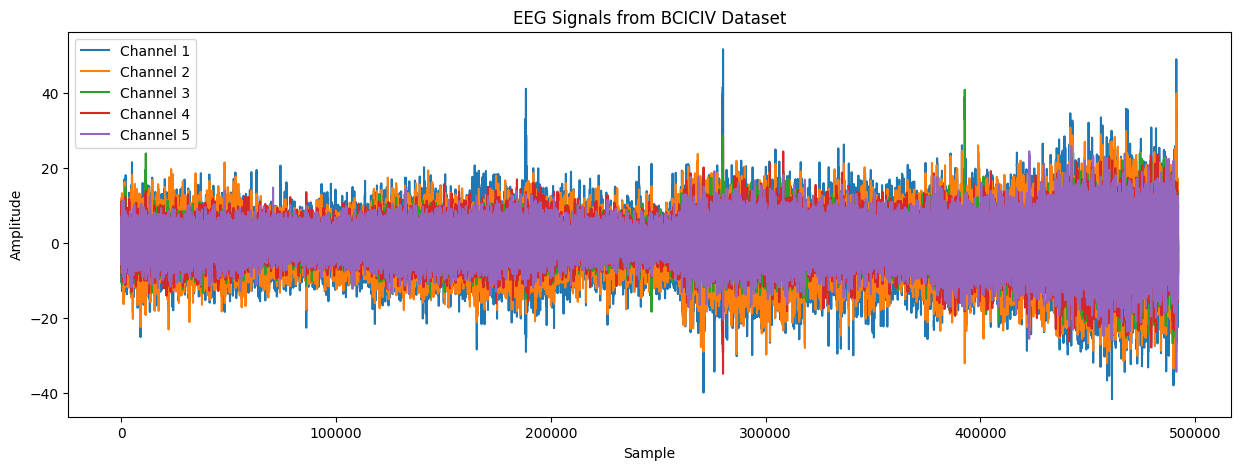

In [35]:
plt.figure(figsize=(15, 5))
for i in range(5):  # Plot the first 5 channels
    plt.plot(eeg_data.iloc[:, i], label=f'Channel {i+1}')
plt.title('EEG Signals from BCICIV Dataset')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


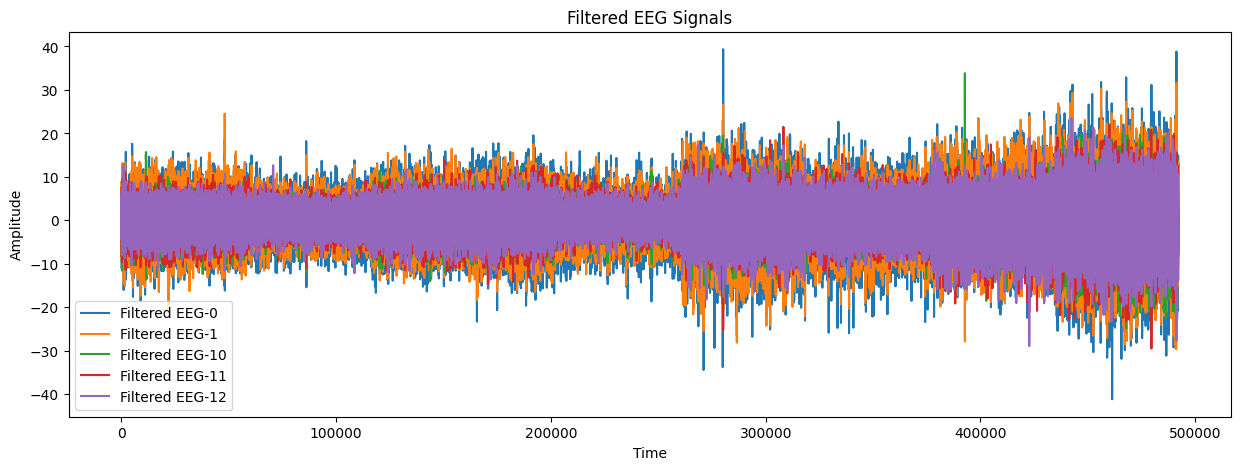

In [36]:
# Define a bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Example: Filtering EEG data between 0.5 Hz and 50 Hz
fs = 250  # Assuming a sampling frequency of 250 Hz
filtered_eeg = bandpass_filter(eeg_data.values, lowcut=0.5, highcut=50, fs=fs)

# Convert the filtered data back into a DataFrame
filtered_eeg_df = pd.DataFrame(filtered_eeg, columns=eeg_columns)

# Plot the filtered data
plt.figure(figsize=(15, 5))
for i in range(5):  # Plot first 5 EEG channels after filtering
    plt.plot(filtered_eeg_df.iloc[:, i], label=f'Filtered {eeg_columns[i]}')
plt.title('Filtered EEG Signals')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Band Decompostion

In [37]:
# Function to compute the power in each frequency band for a given EEG signal
def compute_band_power(eeg_signal, fs=250):
    # Compute FFT
    freqs = np.fft.rfftfreq(len(eeg_signal), 1/fs)
    fft_vals = np.abs(np.fft.rfft(eeg_signal))**2  # Power spectrum

    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    # Compute average power in each band
    band_powers = {}
    for band, (low, high) in bands.items():
        band_freqs = (freqs >= low) & (freqs <= high)
        band_power = np.mean(fft_vals[band_freqs])
        band_powers[band] = band_power

    return band_powers

# Sampling frequency
fs = 250  # Change based on your data

# Apply the function to each EEG channel and create a new DataFrame with band powers
band_power_features = pd.DataFrame([
    compute_band_power(filtered_eeg_df[channel], fs) for channel in filtered_eeg_df.columns
], index=filtered_eeg_df.columns)

print("Band power features:")
print(band_power_features)

Band power features:
               delta         theta         alpha          beta         gamma
EEG-0   1.856568e+08  6.344513e+07  8.509530e+07  1.400509e+07  2.175598e+06
EEG-1   1.549859e+08  6.069940e+07  6.851305e+07  1.001243e+07  1.301511e+06
EEG-10  6.269842e+07  2.391191e+07  4.579724e+07  5.196892e+06  8.496574e+05
EEG-11  8.187376e+07  2.832063e+07  4.174364e+07  4.862433e+06  8.753513e+05
EEG-12  7.046494e+07  2.302482e+07  5.104389e+07  5.132823e+06  6.382613e+05
EEG-13  1.090308e+08  4.665164e+07  1.377114e+08  1.294037e+07  1.536174e+06
EEG-14  1.967075e+08  6.720428e+07  9.093094e+07  1.086970e+07  1.377700e+06
EEG-15  2.113198e+08  7.086126e+07  9.548054e+07  1.117376e+07  1.316608e+06
EEG-16  3.908453e+08  1.375951e+08  1.665691e+08  2.201464e+07  2.702985e+06
EEG-2   2.077388e+08  8.909645e+07  7.943055e+07  1.030886e+07  1.340858e+06
EEG-3   1.480712e+08  6.193911e+07  6.334742e+07  1.000310e+07  1.424843e+06
EEG-4   1.556690e+08  6.228634e+07  7.176533e+07  1.378

In [38]:
# freq_bands = {
#     'delta': (0.5, 4),
#     'theta': (4, 8),
#     'alpha': (8, 13),
#     'beta': (13, 30),
#     'gamma': (30, 45)
# }

# # Calculate band powers using Welch's method
# def calculate_band_powers(filtered_eeg_df, fs=256):  # fs is the sampling frequency
#     band_powers = {}
#     for channel in filtered_eeg_df.columns:
#         f, psd = welch(filtered_eeg_df[channel], fs=fs, nperseg=fs*2)
#         channel_powers = {}
#         for band, (low, high) in freq_bands.items():
#             idx_band = np.logical_and(f >= low, f <= high)
#             channel_powers[band] = np.trapz(psd[idx_band], f[idx_band])
#         band_powers[channel] = channel_powers
#     return pd.DataFrame(band_powers).T

# # Calculate the band power features for usable channels
# band_power_features = calculate_band_powers(usable_data)
# print(band_power_features)


In [39]:
# Scaling the band power features
scaler = StandardScaler()
scaled_band_power = scaler.fit_transform(band_power_features)

# Converting back to a DataFrame
scaled_band_power_df = pd.DataFrame(scaled_band_power, columns=band_power_features.columns, index=band_power_features.index)
print("Scaled band power features:")
print(scaled_band_power_df)

Scaled band power features:
           delta     theta     alpha      beta     gamma
EEG-0   0.389101  0.203205  0.009215  0.663069  0.601084
EEG-1   0.047111  0.112594 -0.454840 -0.224310 -0.443270
EEG-10 -0.981925 -1.101429 -1.090542 -1.294578 -0.983142
EEG-11 -0.768113 -0.955937 -1.203982 -1.368913 -0.952444
EEG-12 -0.895325 -1.130704 -0.943714 -1.308818 -1.235717
EEG-13 -0.465303 -0.350996  1.481678  0.426433 -0.162896
EEG-14  0.512319  0.327261  0.172525 -0.033781 -0.352239
EEG-15  0.675251  0.447945  0.299846  0.033797 -0.425233
EEG-16  2.677018  2.650227  2.289261  2.443216  1.231204
EEG-2   0.635322  1.049724 -0.149313 -0.158428 -0.396258
EEG-3  -0.029991  0.153505 -0.599400 -0.226385 -0.295913
EEG-4   0.054727  0.164964 -0.363824  0.613753  0.762967
EEG-5   0.397044  0.559378  0.763879  1.395189  2.502443
EEG-6  -1.108729 -1.176789 -1.368014 -1.295398 -0.831231
EEG-7  -1.167442 -1.202693 -1.518487 -1.316197 -0.978342
EEG-8   0.202455  0.455985  0.707115  1.367618  2.529530
EEG

### Signal-To-Noise Ratio

In [40]:
def calculate_snr(eeg_data):
    snr_values = {}
    for column in eeg_data.columns:
        if 'EEG' in column:
            signal_power = np.mean(np.square(eeg_data[column]))
            noise_power = np.mean(np.square(eeg_data[column] - eeg_data[column].rolling(window=200).mean()))  # Adjust window size as needed
            snr = 10 * np.log10(signal_power / noise_power)
            snr_values[column] = snr
    return snr_values

# Calculate SNR for the entire DataFrame
snr_data = calculate_snr(df)
df_snr = pd.DataFrame(snr_data, index=['SNR']).transpose()

In [41]:
snr_threshold = 0.24  # Example threshold; tune based on analysis
df_snr['signal_quality'] = df_snr['SNR'].apply(lambda x: 'usable' if x >= snr_threshold else 'unusable')

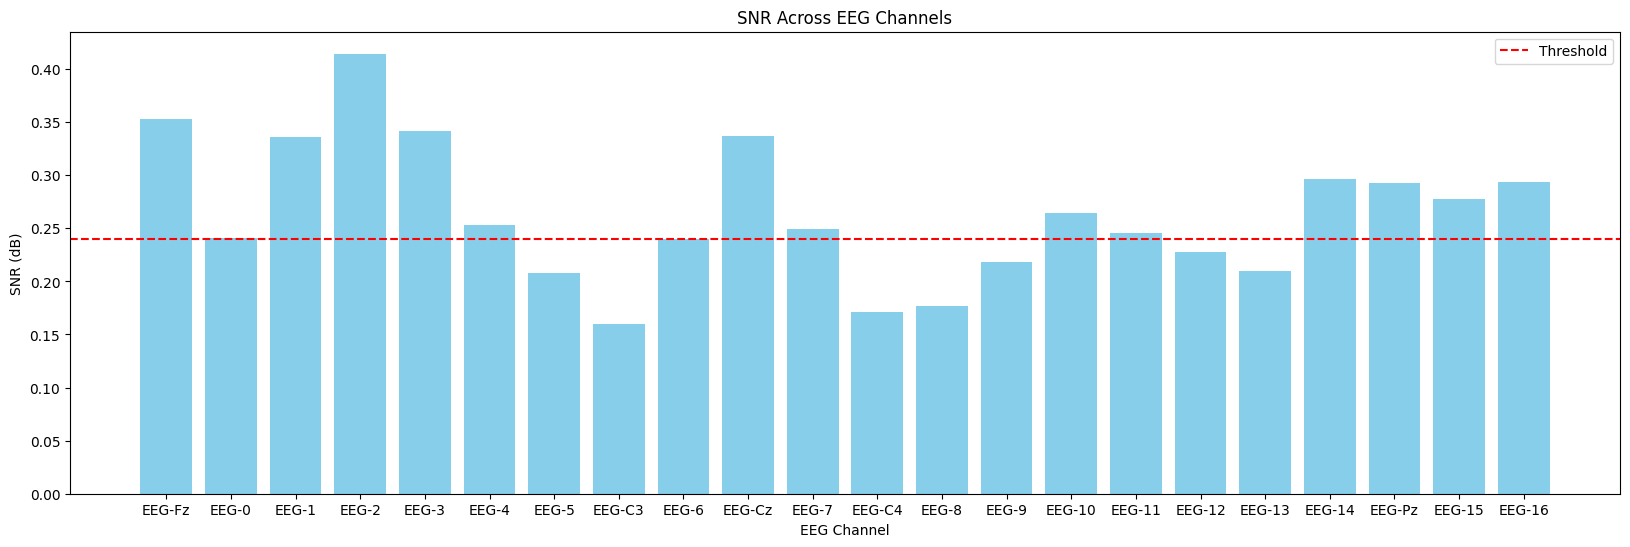

In [42]:
import matplotlib.pyplot as plt

# Plot SNR values for each channel
plt.figure(figsize=(20, 6))
plt.bar(df_snr.index, df_snr['SNR'], color='skyblue')
plt.axhline(y=snr_threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('EEG Channel')
plt.ylabel('SNR (dB)')
plt.title('SNR Across EEG Channels')
plt.legend()
plt.show()


In [43]:
# # # Filter usable epochs
# usable_epochs = df.groupby('epoch').filter(lambda x: (df_snr['signal_quality'] == 'usable').mean() > 0.8)  # Adjust threshold as needed


In [44]:
# # Function to calculate band power using Welch's method
# def calculate_band_powers(eeg_data, fs=256):
#     # Frequency bands in Hz
#     bands = {
#         'delta': (0.5, 4),
#         'theta': (4, 8),
#         'alpha': (8, 13),
#         'beta': (13, 30),
#         'gamma': (30, 50)
#     }
#     band_powers = {band: [] for band in bands}

#     for channel in eeg_data.columns:
#         freqs, psd = welch(eeg_data[channel], fs, nperseg=512)
#         for band, (low, high) in bands.items():
#             band_power = np.trapz(psd[(freqs >= low) & (freqs < high)], freqs[(freqs >= low) & (freqs < high)])
#             band_powers[band].append(band_power)

#     return pd.DataFrame(band_powers, index=eeg_data.columns)

# # Apply to usable data
# band_power_features = calculate_band_powers(usable_epochs)
# print("Extracted Band Power Features:")
# print(band_power_features)

### Computing Band power

In [45]:
# Assuming `snr_data` is a DataFrame with SNR values per channel
# snr_threshold = 0.5
usable_channels = df_snr[df_snr['SNR'] >= snr_threshold].index
usable_data = eeg_data[usable_channels]


In [46]:
usable_data

,EEG-Fz,EEG-0,EEG-1,EEG-2,EEG-3,EEG-4,EEG-Cz,EEG-7,EEG-10,EEG-11,EEG-14,EEG-Pz,EEG-15,EEG-16
0,-1.681412,2.245496,-0.158350,1.163765,-1.523659,-0.575267,0.972209,-2.340592,0.305517,1.137473,0.656704,-2.010063,-1.613804,-1.942455
1,0.420417,0.587559,1.650510,0.970672,1.505904,0.891796,1.316225,0.347175,0.258909,-1.448198,-1.733655,-2.935578,-3.125256,-4.674610
2,0.551365,1.499758,0.121302,2.859433,2.613414,4.636026,0.861236,2.577732,-1.612096,-1.610218,-4.776535,-5.099551,-2.798995,-5.862021
3,3.054916,-1.807238,1.843603,2.286812,5.995872,6.651295,-1.029744,4.446518,-2.672998,-3.452370,-6.081577,-5.476860,-2.932163,-6.874095
4,2.506710,-2.453101,0.221178,0.127278,4.519931,6.249573,-2.163888,4.337764,-2.488783,-3.707608,-4.383690,-4.218426,-1.331932,-5.322692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492043,7.375522,4.646781,3.071135,4.665561,1.087962,0.932088,-2.728143,-2.450199,-3.176987,-4.865313,-1.113059,-4.249327,-1.402272,-6.307621
492044,7.268988,1.952357,5.503664,3.484809,3.227522,-2.738899,-4.446006,-0.847748,-0.500318,-5.655441,-1.805531,-4.453518,-1.801775,-5.974702
492045,4.581222,3.463809,4.427226,4.752120,1.906943,-2.496978,-3.227522,-2.314812,-1.088475,-4.534613,-2.247203,-4.895190,-1.803994,-5.879265
492046,3.504784,4.096355,2.960162,3.187401,2.148864,-3.182791,-5.915288,-2.219375,-1.286006,-5.806364,-0.540439,-3.530222,-0.194886,-1.486953


In [47]:
# Calculate band powers using Welch's method
def calculate_band_powers(data, fs=256):  # fs is the sampling frequency
    band_powers = {}
    for channel in data.columns:
        f, psd = welch(data[channel], fs=fs, nperseg=fs*2)
        channel_powers = {}
        for band, (low, high) in freq_bands.items():
            idx_band = np.logical_and(f >= low, f <= high)
            channel_powers[band] = np.trapz(psd[idx_band], f[idx_band])
        band_powers[channel] = channel_powers
    return pd.DataFrame(band_powers).T

# Calculate the band power features for usable channels
band_power_features = calculate_band_powers(usable_data)
print(band_power_features)


            delta     theta      alpha      beta     gamma
EEG-Fz  21.281398  8.164904   8.813442  4.023599  0.653143
EEG-0   10.896576  4.121292   6.887047  4.058754  0.758487
EEG-1    9.060660  3.989554   5.592890  2.909581  0.450384
EEG-2   12.115444  5.899494   6.521616  2.988456  0.462608
EEG-3    8.742687  4.075649   5.169083  2.886729  0.479840
EEG-4    9.237777  4.084232   5.814533  3.949864  0.797476
EEG-Cz   5.526892  2.659077   2.781586  1.589626  0.359549
EEG-7    2.749347  1.355830   2.463995  1.486582  0.288211
EEG-10   3.704680  1.565027   3.685659  1.524793  0.272997
EEG-11   4.810681  1.842937   3.387937  1.404322  0.268723
EEG-14  11.481666  4.447496   7.389489  3.181613  0.412215
EEG-Pz  11.482327  4.083997   7.287619  2.821618  0.365914
EEG-15  12.337505  4.646168   7.796992  3.290286  0.433438
EEG-16  22.839783  9.116050  13.558064  6.442375  0.872187


In [49]:
# Using the function from before to calculate band powers
# band_power_features = calculate_band_powers(usable_data)
# band_power_features = compute_band_power(usable_data)
# print(band_power_features)

In [50]:
pca = PCA(n_components=4)
reduced_features = pca.fit_transform(band_power_features)

In [51]:
print(reduced_features)

[[ 1.15577857e+01  2.51600892e+00 -1.74324568e-01 -3.74153935e-01]
 [ 7.74425567e-01 -8.41015004e-01  4.05041629e-01 -5.53377907e-01]
 [-1.53828758e+00 -3.90018117e-02  2.21037725e-01  1.16750762e-01]
 [ 2.02438183e+00  7.86941562e-01  3.54999326e-01  7.87865393e-01]
 [-1.95077648e+00  2.01123771e-01  4.63398945e-01  1.71090813e-01]
 [-1.07892143e+00 -5.90802775e-01  9.98155293e-01 -2.93870124e-01]
 [-6.29182621e+00  1.10317992e+00  2.12053368e-01  2.36263117e-02]
 [-9.18982234e+00  5.32444868e-02  8.01975813e-02 -7.31231596e-02]
 [-7.82592433e+00 -5.11855058e-01 -4.01636156e-01  1.08470532e-01]
 [-6.94724796e+00  2.55899371e-01 -4.42440967e-01 -9.18834368e-02]
 [ 1.40800574e+00 -5.44069855e-01 -4.39127164e-01  6.83043269e-02]
 [ 1.18730556e+00 -3.88059758e-01 -8.58575096e-01 -8.74342046e-02]
 [ 2.37343673e+00 -5.42704799e-01 -5.55119997e-01  1.16155805e-03]
 [ 1.54974652e+01 -1.45888897e+00  1.36340080e-01  1.96573070e-01]]


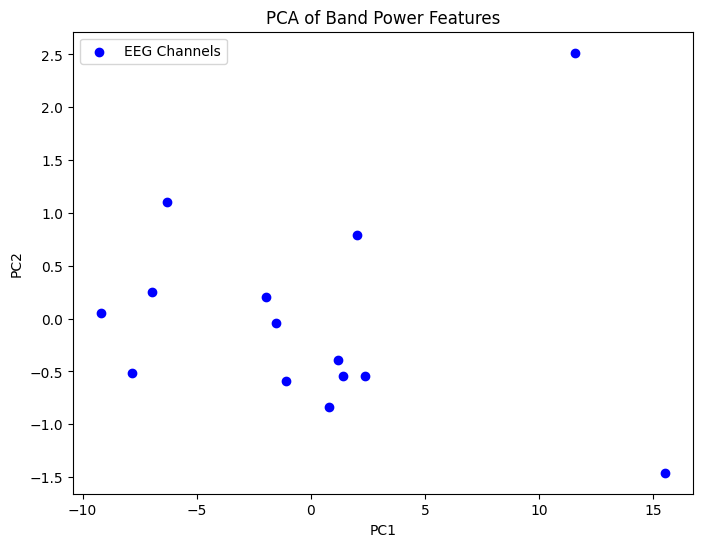

In [52]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(band_power_features)

# Plot the 2D PCA results
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='b', label='EEG Channels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Band Power Features')
plt.legend()
plt.show()


In [53]:
# Perform K-means clustering
n_clusters = 3  # Set desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(band_power_features)

# Add labels to the features DataFrame
band_power_features['Cluster'] = labels
print("Band Power Features with Cluster Labels:")
print(band_power_features)

Band Power Features with Cluster Labels:
            delta     theta      alpha      beta     gamma  Cluster
EEG-Fz  21.281398  8.164904   8.813442  4.023599  0.653143        1
EEG-0   10.896576  4.121292   6.887047  4.058754  0.758487        2
EEG-1    9.060660  3.989554   5.592890  2.909581  0.450384        2
EEG-2   12.115444  5.899494   6.521616  2.988456  0.462608        2
EEG-3    8.742687  4.075649   5.169083  2.886729  0.479840        2
EEG-4    9.237777  4.084232   5.814533  3.949864  0.797476        2
EEG-Cz   5.526892  2.659077   2.781586  1.589626  0.359549        0
EEG-7    2.749347  1.355830   2.463995  1.486582  0.288211        0
EEG-10   3.704680  1.565027   3.685659  1.524793  0.272997        0
EEG-11   4.810681  1.842937   3.387937  1.404322  0.268723        0
EEG-14  11.481666  4.447496   7.389489  3.181613  0.412215        2
EEG-Pz  11.482327  4.083997   7.287619  2.821618  0.365914        2
EEG-15  12.337505  4.646168   7.796992  3.290286  0.433438        2
EEG-16 

In [54]:
# Calculate silhouette score
silhouette_avg = silhouette_score(band_power_features.drop(columns='Cluster'), labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")


Silhouette Score: 0.685


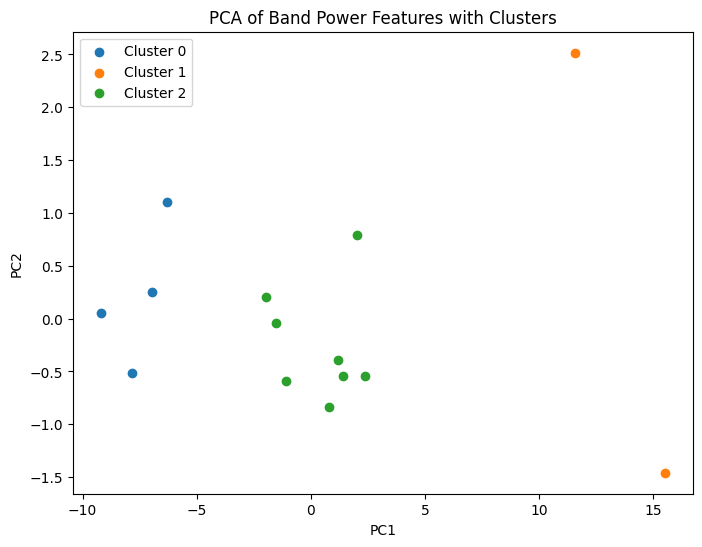

In [55]:
# Plot PCA with cluster labels
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    plt.scatter(
        reduced_features[labels == cluster, 0],
        reduced_features[labels == cluster, 1],
        label=f'Cluster {cluster}'
    )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Band Power Features with Clusters')
plt.legend()
plt.show()


### Advanced Feature Extraction

In [78]:
def calculate_entropy(signal):
    hist, _ = np.histogram(signal, bins=10, density=True)
    return entropy(hist)

eeg_entropy = {channel: calculate_entropy(eeg_data[channel]) for channel in eeg_data}
print(eeg_entropy)

{'EEG-0': 1.009091214304463, 'EEG-1': 1.1260864719891306, 'EEG-10': 0.9507305135832422, 'EEG-11': 1.0743460143309709, 'EEG-12': 1.0153883454072743, 'EEG-13': 0.7223866785653006, 'EEG-14': 1.0771076969344122, 'EEG-15': 1.005083759216406, 'EEG-16': 1.024640380374046, 'EEG-2': 1.082141497223623, 'EEG-3': 1.1572059647636102, 'EEG-4': 1.047215090917886, 'EEG-5': 0.9445731332405036, 'EEG-6': 0.8452045214919678, 'EEG-7': 1.0170633469346415, 'EEG-8': 0.8333029420296446, 'EEG-9': 1.0026535018392955, 'EEG-C3': 0.8745980794956612, 'EEG-C4': 0.940614753675356, 'EEG-Cz': 0.7709058605326939, 'EEG-Fz': 0.9333963998314128, 'EEG-Pz': 1.0457557935910808}


In [79]:
def wavelet_transform(signal):
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    return [np.mean(abs(c)) for c in coeffs]

eeg_wavelet_features = {channel: wavelet_transform(eeg_data[channel]) for channel in eeg_data.columns}
print("Wavelet Features:", eeg_wavelet_features)

Wavelet Features: {'EEG-0': [13.374862750797911, 7.918916109671121, 3.95728138980352, 1.6243606529866694, 1.0657044979481285], 'EEG-1': [12.45708431092541, 7.078810576045973, 3.325105273933899, 1.2996561135539277, 0.8496492515748136], 'EEG-10': [7.9145787936879435, 5.348022107568433, 2.430232551009744, 1.1224460721980358, 0.8129197670227243], 'EEG-11': [8.874588746352183, 5.197677610457212, 2.331060794750876, 1.1998954536550355, 0.8189592565922831], 'EEG-12': [8.283612180247784, 5.5957951292650225, 2.411622804473242, 0.9337815191935274, 0.5320696410299197], 'EEG-13': [10.652354016665193, 8.736725781937634, 3.785835418643845, 1.4607849614964208, 0.7473767193335205], 'EEG-14': [13.64053065299741, 7.881759492114069, 3.4239415918202902, 1.5294987712260983, 0.7222707586826665], 'EEG-15': [13.999939273714533, 8.100814571116155, 3.456256242292057, 1.3593981416276577, 0.7053620332806373], 'EEG-16': [19.154039900675535, 10.827285808839369, 4.778605449346259, 1.9605102852734757, 0.95671338154611

## Signal Quality judment ML Part

In [80]:
df_snr

,SNR,signal_quality
EEG-Fz,0.353239,usable
EEG-0,0.240845,usable
EEG-1,0.335811,usable
EEG-2,0.414493,usable
EEG-3,0.342069,usable
EEG-4,0.252833,usable
EEG-5,0.208029,unusable
EEG-C3,0.160061,unusable
EEG-6,0.239868,unusable
EEG-Cz,0.337034,usable


In [81]:
snr_threshold

0.24

In [82]:
X = pd.DataFrame.from_dict(eeg_entropy, orient='index', columns=['Entropy'])



In [84]:
X['SNR'] = df_snr['SNR']  # Assuming snr_values are computed earlier
y = [1 if snr > snr_threshold else 0 for snr in df_snr['SNR']]  # Binary labels based on SNR threshold


In [85]:
X

,Entropy,SNR
EEG-0,1.009091,0.240845
EEG-1,1.126086,0.335811
EEG-10,0.950731,0.264438
EEG-11,1.074346,0.245225
EEG-12,1.015388,0.227690
EEG-13,0.722387,0.209788
EEG-14,1.077108,0.296564
EEG-15,1.005084,0.277717
EEG-16,1.024640,0.293708
EEG-2,1.082141,0.414493


In [86]:
y

[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]

In [87]:
# y= [x for x in y if x >0] 
# y


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      1.00      0.83         5

    accuracy                           0.71         7
   macro avg       0.36      0.50      0.42         7
weighted avg       0.51      0.71      0.60         7



/Users/saiyarlagadda/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saiyarlagadda/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saiyarlagadda/.pyenv/versions/3.12.0/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

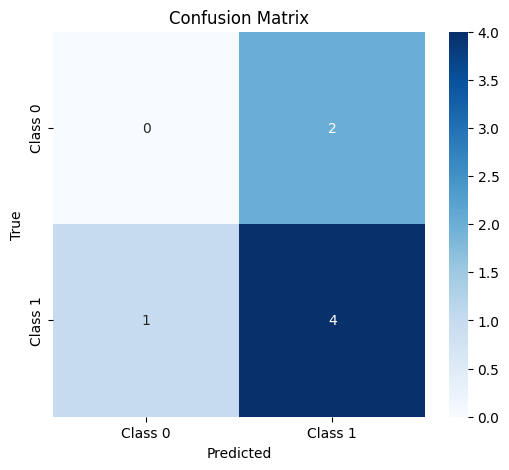

In [95]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

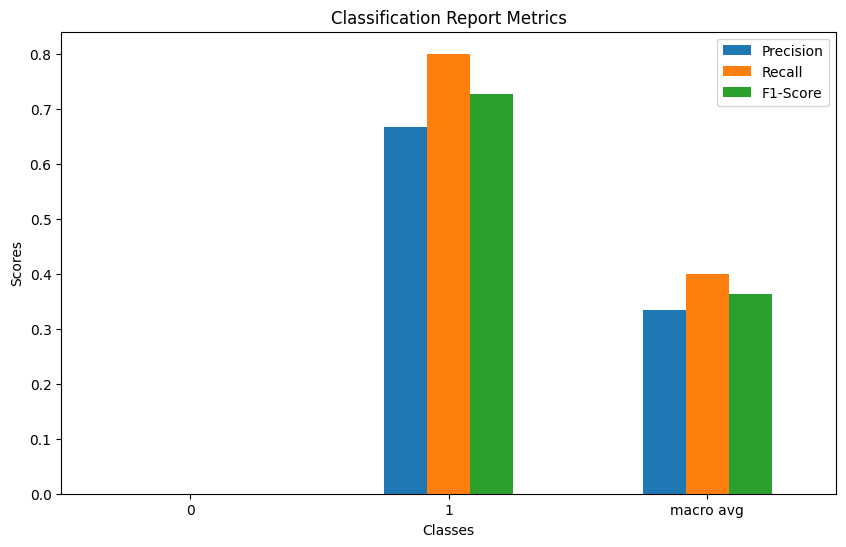

In [96]:
# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert the report to a DataFrame for visualization
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a bar graph
report_df.drop(['accuracy'], errors='ignore').iloc[:-1, :-1].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report Metrics')
plt.ylabel('Scores')
plt.xlabel('Classes')
plt.legend(['Precision', 'Recall', 'F1-Score'])
plt.xticks(rotation=0)
plt.show()

In [94]:
# from sklearn.metrics import roc_curve, auc

# # Assuming binary classification (classes 0 and 1)
# from sklearn.preprocessing import label_binarize

# # Binarize the output (for binary ROC)
# y_true_binary = label_binarize(y_true, classes=[0, 1])

# # Get predicted probabilities for ROC-AUC
# y_scores = [0.9, 0.8, 0.85, 0.7, 0.6, 0.75, 0.4]  # Replace with model's predicted probabilities for class 1

# # Compute ROC curve
# fpr, tpr, thresholds = roc_curve(y_true_binary.ravel(), y_scores)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()
